In [6]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from matplotlib import gridspec
import scipy as sp

import time
import pickle
import re

import urllib.request
from bs4 import BeautifulSoup

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [8]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *
from pubmed_landscape_src.exploration import (
    find_mask_words,
    print_tfidf_top_words,
    print_tfidf_threshold_words,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
variables_path = Path("../../results/variables/2024_baseline")
figures_path = Path("../../results/figures/2024_baseline")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [10]:
plt.style.use("../matplotlib_style.txt")

# Import

In [11]:
%%time
%%memit
# import clean_2024_df
clean_2024_df = pd.read_pickle(variables_path / "clean_2024_df")

peak memory: 66818.48 MiB, increment: 66419.90 MiB
CPU times: user 1min 1s, sys: 51.9 s, total: 1min 53s
Wall time: 1min 52s


In [12]:
pmids_dataset = clean_2024_df.PMID.to_numpy()

In [13]:
all_abstracts = clean_2024_df.AbstractText

In [14]:
tsne = np.load(variables_path / "tsne_bert_sep.npy")

In [15]:
tsne_rot = np.vstack((-tsne[:, 1], -tsne[:, 0])).T

In [16]:
# mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")

In [17]:
# mask_new_retracted_pmids = np.load(variables_path / "mask_new_retracted_pmids.npy")

In [18]:
# Retracted PMIDs scraped from PubMed
retracted_pmids = np.load("../../results/variables/retracted_pmids.npy")

In [19]:
# Retracted PMIDs from Retraction Watch
unique_retracted_pmids_rw_clean_str = np.load(
    "../../results/variables/unique_retracted_pmids_rw_clean_str.npy"
)

In [20]:
new_retracted_pmids = np.load(
    "../../results/variables/new_retracted_pmids.npy"
)

# Retracted papers -- none of this was rerun, identical to section in file 15-rgm-analysis-retracted-papers.ipynb

## Scrape PMIDs 

In [239]:
%%time
retracted_pmids_desc = []

for page in range(1, 50):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=desc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_desc.append(soup.get_text().split()[7:])

retracted_pmids_desc = np.hstack(retracted_pmids_desc)

CPU times: user 831 ms, sys: 68 ms, total: 899 ms
Wall time: 44.9 s


In [17]:
np.save(variables_path / "retracted_pmids_desc", retracted_pmids_desc)

In [240]:
%%time
retracted_pmids_asc = []

for page in range(1, 21):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=asc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_asc.append(soup.get_text().split()[7:])

retracted_pmids_asc = np.hstack(retracted_pmids_asc)

CPU times: user 333 ms, sys: 29 ms, total: 362 ms
Wall time: 18 s


In [19]:
np.save(variables_path / "retracted_pmids_asc", retracted_pmids_asc)

In [241]:
retracted_pmids_asc = np.load(variables_path / "retracted_pmids_asc.npy")
retracted_pmids_desc = np.load(variables_path / "retracted_pmids_desc.npy")

In [218]:
retracted_pmids = np.unique(
    np.hstack((retracted_pmids_desc, retracted_pmids_asc))
)
retracted_pmids.shape

(13569,)

In [224]:
np.save(variables_path / "retracted_pmids", retracted_pmids)

## Retraction watch PMIDs

In [7]:
retraction_watch_data = pd.read_csv("../data/retractions.csv")

In [94]:
retraction_watch_data.columns

Index(['Record ID', 'Title', 'Subject', 'Institution', 'Journal', 'Publisher',
       'Country', 'Author', 'URLS', 'ArticleType', 'RetractionDate',
       'RetractionDOI', 'RetractionPubMedID', 'OriginalPaperDate',
       'OriginalPaperDOI', 'OriginalPaperPubMedID', 'RetractionNature',
       'Reason', 'Paywalled', 'Notes', 'Approved Status'],
      dtype='object')

In [95]:
print(
    f"There are {np.sum(retraction_watch_data.OriginalPaperPubMedID != 0)} retracted papers with PMIDs != 0"
)

There are 25382 retracted papers with PMIDs != 0


In [96]:
retracted_pmids_rw = retraction_watch_data["OriginalPaperPubMedID"][
    retraction_watch_data["OriginalPaperPubMedID"] != 0
]

### NaNs exploration

In [98]:
print(f"There are {np.sum(np.isnan(retracted_pmids_rw.to_numpy()))} NaNs")

There are 5194 NaNs


In [99]:
retraction_watch_data.loc[
    retracted_pmids_rw[np.isnan(retracted_pmids_rw.to_numpy())].index
]

Record ID                                              Title  \
4319       43186  Optimized intelligent data management framewor...   
4320       43185  Towards secure deep learning architecture for ...   
17813      29627  Assessment of the lynchial development of an a...   
20813      26619  Biosoption of chromium(VI) from aqueous soluti...   
30489      16894  Critical radius for radial heat conduction: a ...   
...          ...                                                ...   
46337        859  Therapeutic window of stem cell potential for ...   
46419        776  Ring expansion of a 4,4'-bipyridyl derivative ...   
46439        756  Controversial issues: compartment syndrome, te...   
46633        561  Surgical Management of Cesarean Scar Ectopic P...   
46770        422  Biochemical Predictors of Delirium Tremens in ...   

                                                 Subject  \
4319   (B/T) Business - Manufacturing;(B/T) Computer ...   
4320   (B/T) Computer Science;(B/T) Technology;(BLS) ...   
17813                                   (SOC) Education;   
20813                (BLS) Biochemistry;(PHY) Chemistry;   
30489  (PHY) Energy;(PHY) Engineering - Mechanical;(P...   
...                                                  ...   
46337  (BLS) Biology - Cancer;(BLS) Biology - Cellula...   
46419                                   (PHY) Chemistry;   
46439           (HSC) Medicine - Anesthesia/Anaesthesia;   
46633  (HSC) Medicine - Obstetrics/Gynecology;(HSC) M...   
46770  (BLS) Toxicology;(HSC) Biostatistics/Epidemiol...   

                                             Institution  \
4319   Department of Computer Science, College of Com...   
4320   Department of Computer Science and Engineering...   
17813  Associate Professor, Department of Pedagogy an...   
20813  School of Municipal and Environmental Engineer...   
30489  Mechanical Engineering and Energy Processes De...   
...                                                  ...   
46337  Neuro-Oncology Research Laboratory Center for ...   
46419  Department of Material Science, Faculty of Sci...   
46439  Department of Pediatric Anesthesiology and Int...   
46633  Department of Obstetrics and Gynecology, Sheng...   
46770  Department of Psychiatry, Padmashree Dr D Y Pa...   

                                                 Journal  \
4319                       Complex & Intelligent Systems   
4320                       Complex & Intelligent Systems   
17813  Education and Science (ÐÐ±ÑÐ°Ð·Ð¾Ð²Ð°Ð½Ð¸Ðµ ...   
20813  2011 5th International Conference on Bioinform...   
30489                        Applied Thermal Engineering   
...                                                  ...   
46337                                  Stem Cell Reviews   
46419                                  Angewandte Chemie   
46439      Pediatric Anesthesia (Paediatric Anaesthesia)   
46633      Acta Obstetricia et Gynecologica Scandinavica   
46770  Alcohol and Alcoholism: International Journal ...   

                                               Publisher        Country  \
4319                                            Springer   Saudi Arabia   
4320                                            Springer          India   
17813  Russian State Vocational Pedagogical Universit...         Russia   
20813  IEEE: Institute of Electrical and Electronics ...          China   
30489                                           Elsevier  United States   
...                                                  ...            ...   
46337                                           Springer  United States   
46419                                              Wiley          Japan   
46439                                              Wiley          Italy   
46633                                              Wiley          China   
46770                            Oxford University Press          India   

                                                  Author  \
4319   Abdulmajeed Alsufyani;Y

In [100]:
retracted_pmids_rw_clean = retracted_pmids_rw[
    ~np.isnan(retracted_pmids_rw.to_numpy())
]
print(
    f"There are actually {len(retracted_pmids_rw_clean)} retracted papers with PMIDs"
)

There are actually 20188 retracted papers with PMIDs


### Check for duplicates

In [101]:
retracted_pmids_rw_clean

0        32264640.0
1        32262521.0
2        23151593.0
3        27341836.0
4        37067550.0
            ...    
47180      217854.0
47181     1791149.0
47182     2372964.0
47183    21278292.0
47184    18636547.0
Name: OriginalPaperPubMedID, Length: 20188, dtype: float64

In [102]:
unique_retracted_pmids_rw_clean = np.unique(retracted_pmids_rw_clean)
print(
    f"There are {len(unique_retracted_pmids_rw_clean)} unique retracted PMIDs"
)

There are 18786 unique retracted PMIDs


#### Sanity check

In [103]:
values, counts = np.unique(retracted_pmids_rw_clean, return_counts=True)

In [104]:
print(len(values))
print(len(counts))
values[counts > 1]

18786
18786


array([ 1341533.,  1518830.,  2141811., ..., 35940183., 36608046.,
       37013495.])

In [105]:
retraction_watch_data[retraction_watch_data.OriginalPaperPubMedID == 1341533.0]

Record ID                                              Title  \
44195       3053  Laparoscopic segmental resection for infiltrat...   
44295       2951  Laparoscopic segmental resection for infiltrat...   

                                                 Subject  \
44195  (HSC) Medicine - Obstetrics/Gynecology;(HSC) M...   
44295  (HSC) Medicine - Obstetrics/Gynecology;(HSC) M...   

                                             Institution  \
44195  Center for Special Pelvic Surgery, Atlanta, Ge...   
44295  Center for Special Pelvic Surgery, Atlanta, Ge...   

                                                 Journal  \
44195  Surgical Laparoscopy, Endoscopy & Percutaneous...   
44295  Surgical Laparoscopy, Endoscopy & Percutaneous...   

                             Publisher        Country  \
44195  Lippincott Williams and Wilkins  United States   
44295  Lippincott Williams and Wilkins  United States   

                                                  Author URLS  \
44195  Camran Nezhat;Farr Nezhat;Earl Pennington;Wayn...  NaN   
44295  Camran Nezhat;Farr Nezhat;Earl Pennington;Wayn...  NaN   

           ArticleType  ... RetractionDOI RetractionPubMedID  \
44195  Clinical Study;  ...           NaN                NaN   
44295  Clinical Study;  ...           NaN         11440025.0   

       OriginalPaperDate OriginalPaperDOI OriginalPaperPubMedID  \
44195      9/1/1992 0:00              NaN             1341533.0   
44295      9/1/1992 0:00              NaN             1341533.0   

            RetractionNature  \
44195  Expression of concern   
44295             Retraction   

                                                  Reason Paywalled  \
44195  +Civil Proceedings;+Concerns/Issues About Data...       Yes   
44295  +Civil Proceedings;+Concerns/Issues About Resu...       Yes   

                                                   Notes  \
44195  NO PMID for Notice. No DOIs for Original Artic...   
44295                                                NaN   

                               Approved Status  
44195  Approved by Admin on May 18 2017 2:35PM  
44295  Approved by Admin on May 18 2017 2:44PM  

[2 rows x 21 columns]

### Transform to string

In [106]:
unique_retracted_pmids_rw_clean_str = np.array(
    [str(int(elem)) for elem in unique_retracted_pmids_rw_clean.tolist()]
)
print(
    f"There are {len(unique_retracted_pmids_rw_clean_str)} unique retracted PMIDs"
)

There are 18786 unique retracted PMIDs


In [210]:
np.save(
    variables_path / "unique_retracted_pmids_rw_clean_str",
    unique_retracted_pmids_rw_clean_str,
)

#### Sanity check

In [107]:
len(unique_retracted_pmids_rw_clean)

18786

In [108]:
len(
    np.unique(
        np.array(
            [int(elem) for elem in unique_retracted_pmids_rw_clean.tolist()]
        )
    )
)

18786

### Check how many of them are there in the scraped ids

In [109]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [110]:
retracted_pmids

array(['10026173', '10047653', '10050223', ..., '9931130', '9933281',
       '9987036'], dtype='<U8')

In [112]:
print(
    f"The old set has {len(set(retracted_pmids).difference(set(unique_retracted_pmids_rw_clean_str)))} papers that are not in the new set"
)
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(retracted_pmids)))} papers that are not in the old set"
)

The old set has 481 papers that are not in the new set
The new set has 5698 papers that are not in the old set


In [252]:
print(
    f"The old set has {len(set(pmids_dataset[mask_retracted_pmids]).difference(set(pmids_dataset[mask_retracted_pmids_rw])))} papers that are not in the new set, contained in our dataset"
)
print(
    f"The new set has {len(set(pmids_dataset[mask_retracted_pmids_rw]).difference(set(pmids_dataset[mask_retracted_pmids])))} papers that are not in the old set, contained in our dataset"
)

The old set has 234 papers that are not in the new set, contained in our dataset
The new set has 3901 papers that are not in the old set, contained in our dataset


#### Sanity check

In [124]:
# set(retracted_pmids).difference(set(unique_retracted_pmids_rw_clean_str))

In [126]:
clean_df_updated_reparsed_filtered[
    clean_df_updated_reparsed_filtered.PMID
    == np.array(
        set(retracted_pmids).difference(
            set(unique_retracted_pmids_rw_clean_str)
        )
    )
]

Empty DataFrame
Columns: [PMID, Title, AbstractText, Language, Journal, Date, NameFirstAuthor, NameLastAuthor, ISSN, filename]
Index: []

In [127]:
print(
    f"The old set has {len(set(retracted_pmids).difference(set(pmids_dataset)))} papers that are not in the dataset we use"
)
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(pmids_dataset)))} papers that are not in the dataset we use"
)

The old set has 1582 papers that are not in the dataset we use
The new set has 3132 papers that are not in the dataset we use


In [176]:
13569 - 11998

1571

In [ ]:
print(len(np.unique(pmids_dataset[mask_retracted_pmids])))

11987


## Difference (only new PMIDs)

In [224]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [210]:
unique_retracted_pmids_rw_clean_str = np.load(
    variables_path / "unique_retracted_pmids_rw_clean_str.npy"
)

In [231]:
print(
    f"The new set has {len(set(pmids_dataset[mask_retracted_pmids_rw]).difference(set(pmids_dataset[mask_retracted_pmids])))} papers that are not in the old set, contained in our dataset"
)

The new set has 3901 papers that are not in the old set, contained in our dataset


In [232]:
print(
    f"The new set has {len(set(np.unique(pmids_dataset[mask_retracted_pmids_rw])).difference(set(np.unique(pmids_dataset[mask_retracted_pmids]))))} papers that are not in the old set, contained in our dataset"
)

The new set has 3901 papers that are not in the old set, contained in our dataset


In [211]:
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(retracted_pmids)))} papers that are not in the old set"
)

The new set has 5698 papers that are not in the old set


In [213]:
new_retracted_pmids = set(unique_retracted_pmids_rw_clean_str).difference(
    set(retracted_pmids)
)

In [223]:
np.save(
    variables_path / "new_retracted_pmids", np.array(list(new_retracted_pmids))
)

# Mask

## Scraped

### Good solution

In [22]:
%%time
dict_map = dict()
for elem in retracted_pmids:
    dict_map[elem] = 1

CPU times: user 3.95 ms, sys: 926 µs, total: 4.87 ms
Wall time: 4.82 ms


In [23]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.61 s, sys: 14 ms, total: 1.62 s
Wall time: 1.61 s


In [17]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 1.07 s, sys: 7.76 ms, total: 1.07 s
Wall time: 1.07 s


In [18]:
mask_retracted_pmids = pre_mask == 1

In [19]:
np.save(variables_path / "mask_retracted_pmids", mask_retracted_pmids)

## Retraction watch

In [20]:
%%time
dict_map = dict()
for elem in unique_retracted_pmids_rw_clean_str:
    dict_map[elem] = 1

CPU times: user 6.03 ms, sys: 37 µs, total: 6.07 ms
Wall time: 6.04 ms


In [21]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.59 s, sys: 3.64 ms, total: 1.59 s
Wall time: 1.59 s


In [22]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 1.03 s, sys: 11.5 ms, total: 1.04 s
Wall time: 1.04 s


In [23]:
mask_retracted_pmids_rw = pre_mask == 1

In [24]:
np.sum(mask_retracted_pmids_rw)

17096

In [25]:
np.save(variables_path / "mask_retracted_pmids_rw", mask_retracted_pmids_rw)

## Difference (only new PMIDs)

In [28]:
type(new_retracted_pmids)

numpy.ndarray

In [29]:
%%time
dict_map = dict()
for elem in new_retracted_pmids:
    dict_map[elem] = 1

CPU times: user 2.03 ms, sys: 25 µs, total: 2.05 ms
Wall time: 2.07 ms


In [30]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.35 s, sys: 3.28 ms, total: 1.35 s
Wall time: 1.35 s


In [31]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 1.03 s, sys: 28 ms, total: 1.06 s
Wall time: 1.05 s


In [32]:
mask_new_retracted_pmids = pre_mask == 1

In [33]:
np.sum(mask_new_retracted_pmids)

4843

In [34]:
np.save(variables_path / "mask_new_retracted_pmids", mask_new_retracted_pmids)

# Mentions in the abstract
We extract the papers that mention the following words ("retracted", "retraction", "withdrawal") in the abstract to exclude them from the plot. We want to highlight only retracted papers that do not explicitly state in their abstract that they have been retracted.

In [24]:
mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")
mask_retracted_pmids_rw = np.load(
    variables_path / "mask_retracted_pmids_rw.npy"
)
mask_new_retracted_pmids = np.load(
    variables_path / "mask_new_retracted_pmids.npy"
)

## Scraped

In [25]:
abstracts = all_abstracts[mask_retracted_pmids]

In [26]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted)[0]),
)

Number of papers with uncapitalized word ' retracted':  363
Number of papers with capitalized word 'Retracted':  24
Number of papers with uppercased word 'RETRACTED':  3
Number of total papers with retracted:  366


In [27]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction)[0]),
)

Number of papers with uncapitalized word ' retraction':  88
Number of papers with capitalized word 'Retraction':  26
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  100


In [28]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  45
Number of papers with capitalized word 'Withdrawal':  330
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  371


In [29]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  40
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  40


In [30]:
print(
    f"There are {np.sum((~mask_retraction)& (~mask_retracted)& (~mask_withdrawal)& (~mask_withdrawn))} intact papers"
)

There are 12134 intact papers


## Retraction watch

In [31]:
abstracts = all_abstracts[mask_retracted_pmids_rw]

In [32]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_rw)[0]),
)

Number of papers with uncapitalized word ' retracted':  468
Number of papers with capitalized word 'Retracted':  25
Number of papers with uppercased word 'RETRACTED':  3
Number of total papers with retracted:  471


In [33]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_rw)[0]),
)

Number of papers with uncapitalized word ' retraction':  161
Number of papers with capitalized word 'Retraction':  52
Number of papers with uppercased word 'RETRACTION':  1
Number of total papers with retraction:  177


In [34]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  94
Number of papers with capitalized word 'Withdrawal':  588
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  675


In [35]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  278
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  278


In [36]:
print(
    f"There are {np.sum((~mask_retraction_rw)& (~mask_retracted_rw)& (~mask_withdrawal_rw)& (~mask_withdrawn_rw))} intact papers"
)

There are 16244 intact papers


## Difference (only new PMIDs)

In [37]:
abstracts = all_abstracts[mask_new_retracted_pmids]

In [38]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_new)[0]),
)

Number of papers with uncapitalized word ' retracted':  114
Number of papers with capitalized word 'Retracted':  1
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  114


In [39]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_new)[0]),
)

Number of papers with uncapitalized word ' retraction':  76
Number of papers with capitalized word 'Retraction':  28
Number of papers with uppercased word 'RETRACTION':  1
Number of total papers with retraction:  81


In [40]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_new)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  51
Number of papers with capitalized word 'Withdrawal':  271
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  318


In [41]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_new)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  244
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  244


In [42]:
print(
    f"There are {np.sum((~mask_retraction_new)& (~mask_retracted_new)& (~mask_withdrawal_new)& (~mask_withdrawn_new))} intact papers"
)

There are 4429 intact papers


## Intact PMIDs

In [43]:
intact_retracted_pmids = pmids_dataset[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]
print(intact_retracted_pmids.shape)
np.save(variables_path / "intact_retracted_pmids", intact_retracted_pmids)

(12134,)


In [44]:
print(pmids_dataset.shape)
print(tsne.shape)

(23389083,)
(23389083, 2)


In [45]:
intact_retracted_pmids_rw = pmids_dataset[mask_retracted_pmids_rw][
    (~mask_retraction_rw)
    & (~mask_retracted_rw)
    & (~mask_withdrawal_rw)
    & (~mask_withdrawn_rw)
]
print(intact_retracted_pmids_rw.shape)
np.save(
    variables_path / "intact_retracted_pmids_rw", intact_retracted_pmids_rw
)

(16244,)


In [46]:
intact_new_retracted_pmids = pmids_dataset[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]
print(intact_new_retracted_pmids.shape)
np.save(
    variables_path / "intact_new_retracted_pmids", intact_new_retracted_pmids
)

(4429,)


# Plot

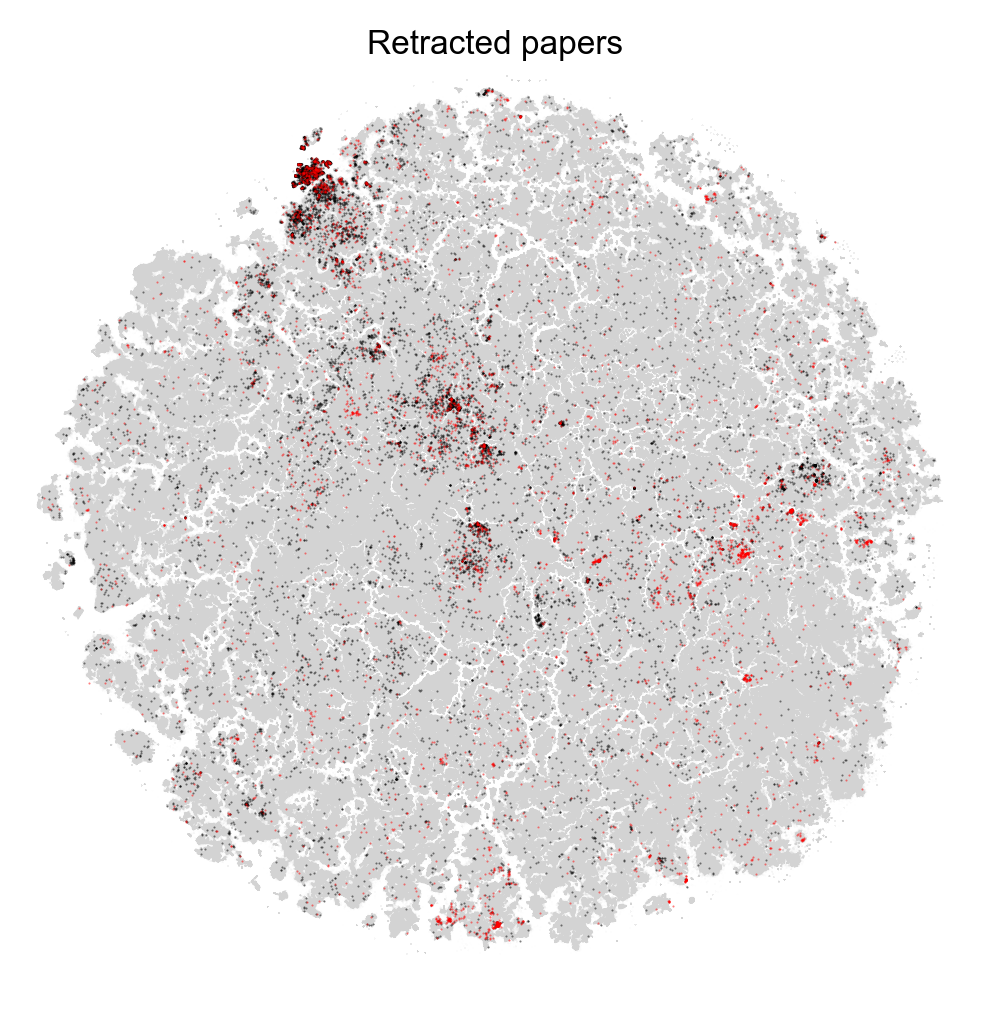

In [58]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-220, 220)
y_lim = (-220, 220)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)


ax.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.scatter(
    *subregion_rw.T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.set_title("Retracted papers")
ax.axis("equal")
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.axis("off")

fig.savefig(figures_path / "retracted_papers_plus_rw_v1.png")

In [59]:
# with the new data

print(f"There are {tsne.shape[0]} papers")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

print(
    "Number of retracted papers: ",
    subregion.shape[0] + subregion_rw.shape[0],
)
print(
    "Fraction of retracted papers: ",
    (subregion.shape[0] + subregion_rw.shape[0]) / tsne.shape[0] * 100,
)

There are 23389083 papers
Number of retracted papers:  16563
Fraction of retracted papers:  0.07081508924484127


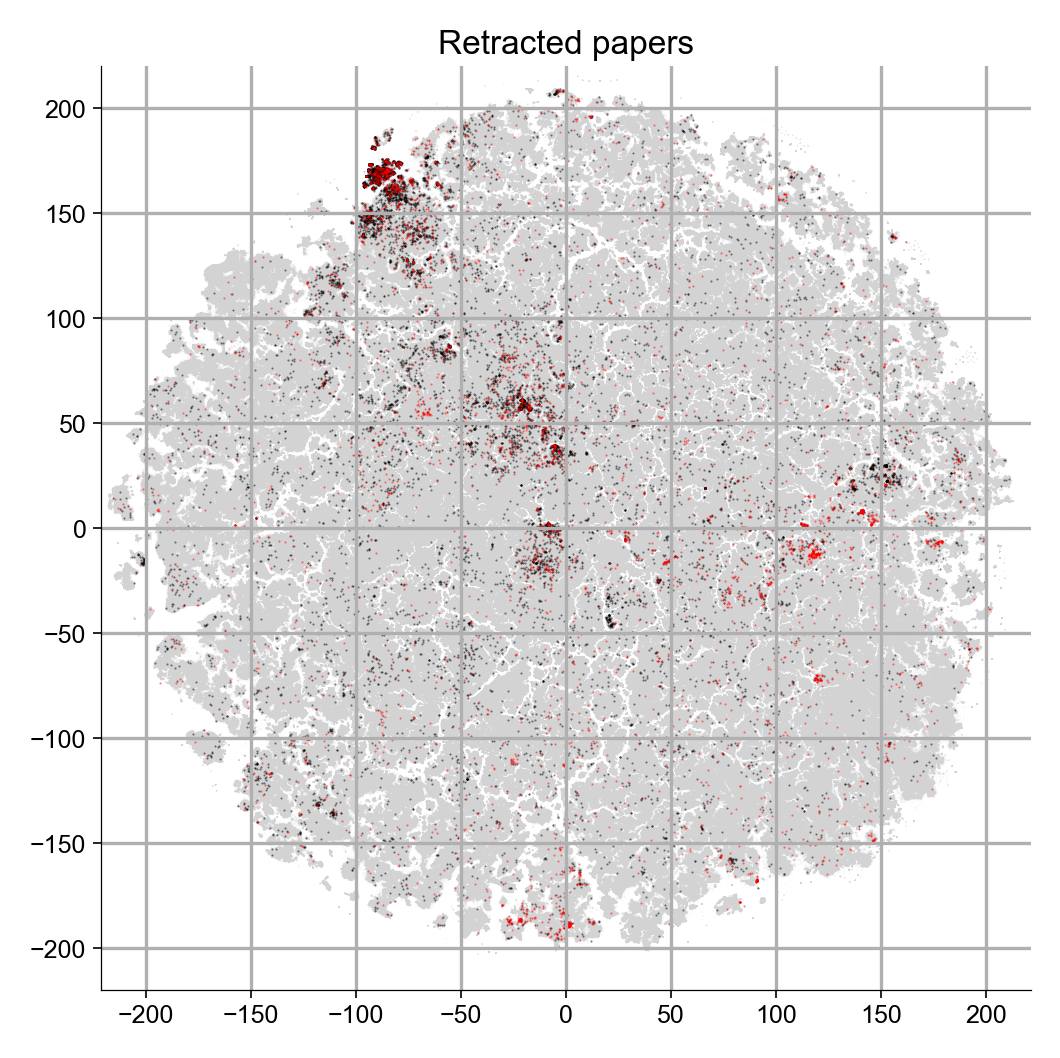

In [60]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-220, 220)
y_lim = (-220, 220)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)


ax.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.scatter(
    *subregion_rw.T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.set_title("Retracted papers")
ax.axis("equal")
ax.grid()
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
# ax.axis("off")

fig.savefig(figures_path / "retracted_papers_plus_rw_v2.png")

## First inset

In [62]:
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.linewidth"] = 0.5

(160.0, 180.0)

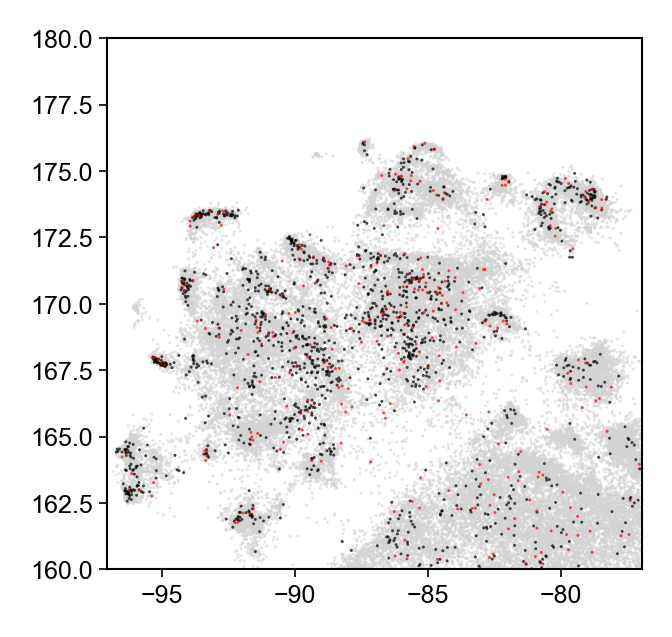

In [67]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -77
left = -97
top = 180
bottom = 160

#old values
# right = -35
# left = -55
# top = 220
# bottom = 200

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.grid()
# ax1.set_xticks([])
# ax1.set_yticks([])

In [68]:
# mask island 1, ONLY PubMed flagged papers
right = -77
left = -97
top = 180
bottom = 160
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 51785 papers in the zoom
There are 50301 non-retracted papers in the zoom
Number of retracted papers:  1484
Fraction of retracted papers:  2.8656946992372307


In [69]:
# mask island 1, with the new data
right = -77
left = -97
top = 180
bottom = 160
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 51785 papers in the zoom
There are 50007 non-retracted papers in the zoom
Number of retracted papers:  1778
Fraction of retracted papers:  3.4334266679540404


### Other top island

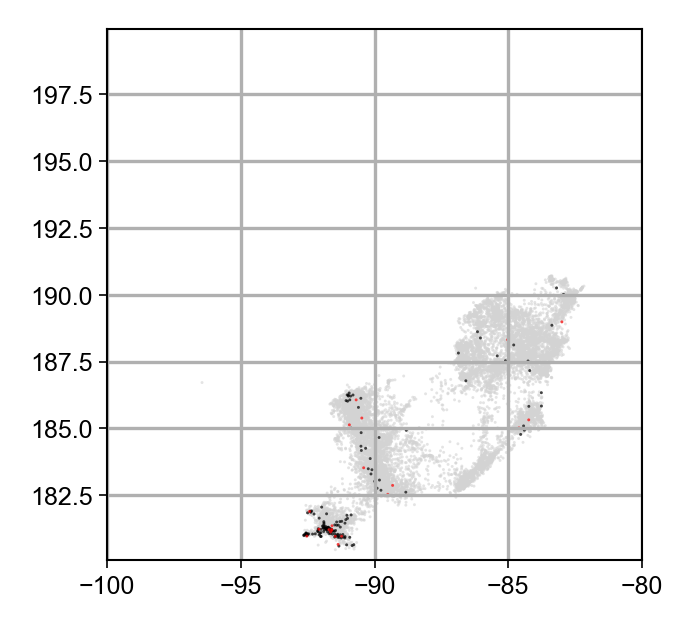

In [70]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -80
left = -100
top = 200
bottom = 180

# right = -35
# left = -55
# top = 220
# bottom = 200

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
ax1.grid()
# ax1.set_xticks([])
# ax1.set_yticks([])

In [82]:
right = -80
left = -100
top = 200
bottom = 180

mask_island = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

for elem in clean_2024_df[mask_island].AbstractText.to_list()[:5]:
    print(elem)
    print("-----------")

The treatment of malignant brain gliomas remains a challenge, despite the availability of the classical triad of surgery, radiotherapy, and chemotherapy. There is thus the need for investigations into other forms of treatment strategies, such as gene therapy. Using antisense technology we have targeted glycogen metabolism, since malignant astrocytes present a high content of glycogen. In vitro rat C6‑glioma cells, transfected with antisense glycogen synthase (C6‑AS cells) exhibited a decreased expression of glycogen synthase and reduced activity of glycogen synthesis, along with attenuated invasiveness. In vivo tumors induced by C6‑AS cells in nude mice exhibited a significant reduction in tumor growth compared with controls. This reduction could be mediated by the induction of MCH‑I expression. The inhibition of glycogen synthesis by antisense glycogen synthase validates a putative target and a new approach for further study to advance the much‑needed efficacy of intervention strategi

#### Lower part of top island

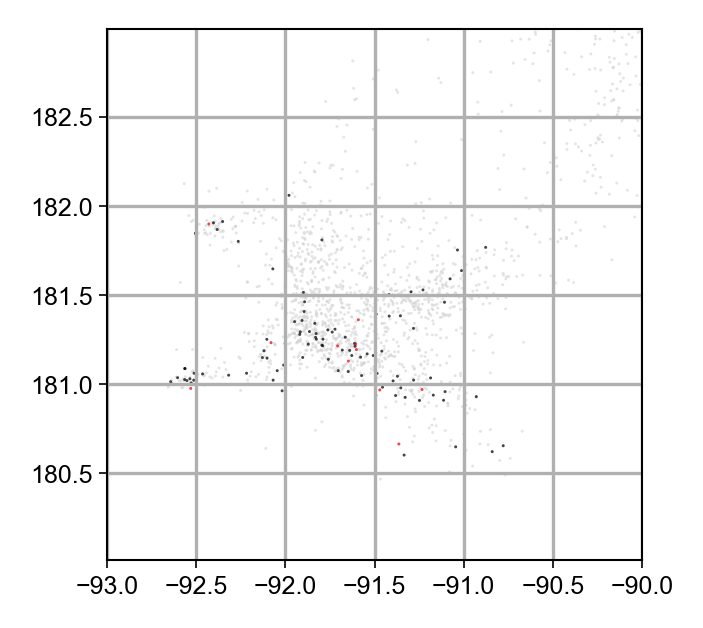

In [71]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -90
left = -93
top = 183
bottom = 180

# right = -35
# left = -55
# top = 220
# bottom = 200

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
ax1.grid()
# ax1.set_xticks([])
# ax1.set_yticks([])

In [72]:
# mask island 1, with the new data
right = -90
left = -93
top = 183
bottom = 180
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 1634 papers in the zoom
There are 1526 non-retracted papers in the zoom
Number of retracted papers:  108
Fraction of retracted papers:  6.609547123623011


In [83]:
right = -90
left = -93
top = 183
bottom = 180

mask_island = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

# for elem in clean_2024_df[mask_island].AbstractText.to_list()[:5]:
#     print(elem)
#     print("-----------")

clean_2024_df[mask_island]

PMID                                              Title  \
22214483  23128435  MicroRNA-125b expression in gastric adenocarci...   
22258589  23175237  MicroRNA-27a inhibitors alone or in combinatio...   
22312358  23232714  High expression of microRNA‑127 is involved in...   
22320748  23241652  Modulation of miR‑122 expression affects the i...   
22332885  23254855  miR-24-3p and miR-27a-3p promote cell prolifer...   
...            ...                                                ...   
36176503  37711058  MBNL1‑AS1 attenuates tumor cell proliferation ...   
36236831  37772373  METTL3 promotes proliferation and migration of...   
36262500  37800632  RNA‑binding protein quaking 5 inhibits the pro...   
36381146  37921054  Knockdown of lncRNA MALAT1 induces pyroptosis ...   
36434994  37975233  MicroRNA‑606 inhibits the growth and metastasi...   

                                               AbstractText Language  \
22214483  MicroRNAs exert regulatory effects on a number...      eng   
22258589  MicroRNA-27a (miR‑27a) is an oncogene that con...      eng   
22312358  microRNAs (miRs) are small endogenous non‑codi...      eng   
22320748  Type I interferon (IFN) is believed to play si...      eng   
22332885  MicroRNAs (miRNAs) are small, non‑coding RNAs ...      eng   
...                                                     ...      ...   
36176503  Dysregulation of long non‑coding RNAs (lncRNAs...      eng   
36236831  N6‑methyladenosine (m6A) serves an essential r...      eng   
36262500  It was recently reported that netrin‑4 (Ntn‑4)...      eng   
36381146  The aim of the present study was to elucidate ...      eng   
36434994  Triple‑negative breast cancer (TNBC) is associ...      eng   

                                    Journal      Date NameFirstAuthor  \
22214483         Molecular medicine reports  2013 Jan         Zhao-Xu   
22258589         Molecular medicine reports  2013 Feb        Dongxiao   
22312358         Molecular medicine reports  2013 Feb           Ji-Ae   
22320748         Molecular medicine reports  2013 Feb           Aimei   
22332885  International journal of oncology  2013 Feb           Weiyi   
...                                     ...       ...             ...   
36176503                   Oncology reports  2023 Oct      Wang-Sheng   
36236831         Molecular medicine reports  2023 Nov           Yeqiu   
36262500                   Oncology reports  2023 Nov            Zhuo   
36381146  International journal of oncology   2023 12            Tian   
36434994                   Oncology reports   2024 01           Sujin   

         NameLastAuthor       ISSN  \
22214483       Kai-Shan  1791-3004   
22258589             Li  1791-3004   
22312358        Nam-Pyo  1791-3004   
22320748        Fengmin  1791-3004   
22332885       Songshan  1791-2423   
...                 ...        ...   
36176503     Xiang-Ming  1791-2431   
36236831          Xilin  1791-3004   
36262500       Hongfang  1791-2431   
36381146            Dan  1791-2423   
36434994       Soonchul  1791-2431   

                                     AffiliationFirstAuthor  \
22214483  Department of Hepatobiliary Surgery, Xijing Ho...   
22258589  Department of General Surgery, The Second Affi...   
22312358  Department of Oral Pathology, School of Dentis...   
22320748  Department of Microbiology, Harbin Medical Uni...   
22332885  Key Laboratory of Gene Engineering of the Mini...   
...                                                     ...   
36176503  Department of General Surgery, The First Affil...   
36236831  Fourth Department of Orthopedic Surgery, Centr...   
36262500  Department of Thoracic Surgery, Fourth Affilia...   
36381146  Department of Obstetrics and Gynaecology, The ...   
36434994  Department of Orthopedic Surgery, CHA Bundang ...   

                                      AffiliationLastAuthor           filename  
22214483                                                     pubmed24n0741.xml  
22258589           

## Second inset

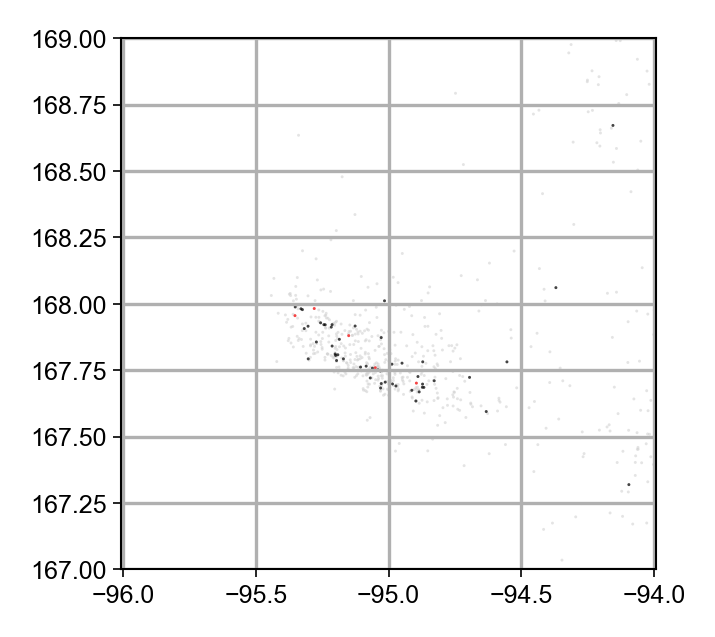

In [93]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -94
left = -96
top = 169
bottom = 167

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.grid()
# ax1.set_xticks([])
# ax1.set_yticks([])

In [94]:
# mask island 1
right = -94
left = -96
top = 169
bottom = 167
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 606 papers in the zoom
There are 555 non-retracted papers in the zoom
Number of retracted papers:  51
Fraction of retracted papers:  8.415841584158416


In [95]:
# mask island 1
right = -94
left = -96
top = 169
bottom = 167
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 606 papers in the zoom
There are 550 non-retracted papers in the zoom
Number of retracted papers:  56
Fraction of retracted papers:  9.24092409240924


In [99]:
right = -94
left = -96
top = 169
bottom = 167

mask_island = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

for elem in clean_2024_df[mask_island].Title.to_list()[:10]:
    print(elem)
    print("-----------")

clean_2024_df[mask_island]

MicroRNA-1/206 targets c-Met and inhibits rhabdomyosarcoma development.
-----------
MicroRNA-21 is involved in osteosarcoma cell invasion and migration.
-----------
microRNA-143, down-regulated in osteosarcoma, promotes apoptosis and suppresses tumorigenicity by targeting Bcl-2.
-----------
MicroRNA-199a-3p is downregulated in human osteosarcoma and regulates cell proliferation and migration.
-----------
miR-125b suppresses the proliferation and migration of osteosarcoma cells through down-regulation of STAT3.
-----------
MicroRNA-34a inhibits the proliferation and metastasis of osteosarcoma cells both in vitro and in vivo.
-----------
MicroRNA-145 targets vascular endothelial growth factor and inhibits invasion and metastasis of osteosarcoma cells.
-----------
Down-regulation of miR-183 promotes migration and invasion of osteosarcoma by targeting Ezrin.
-----------
microRNA-9 targets matrix metalloproteinase 14 to inhibit invasion, metastasis, and angiogenesis of neuroblastoma cells.


PMID                                              Title  \
19081606  19710019  MicroRNA-1/206 targets c-Met and inhibits rhab...   
19804297  20480266  MicroRNA-21 is involved in osteosarcoma cell i...   
20176735  20878132  microRNA-143, down-regulated in osteosarcoma, ...   
20894356  21666078  MicroRNA-199a-3p is downregulated in human ost...   
21294263  22093834  miR-125b suppresses the proliferation and migr...   
...            ...                                                ...   
35889494  37420040  miR-1-3p Inhibits Osteosarcoma Cell Proliferat...   
36000871  37532779  hsa-miR-199b-3p suppresses osteosarcoma progre...   
36289585  37828372  MicroRNA-409-5p Inhibits GIST Tumorigenesis an...   
36359622  37899376  Tumor-suppressive microRNA-152 inhibits the pr...   
36364415  37904207  miR-3195 suppresses the malignant progression ...   

                                               AbstractText Language  \
19081606  MicroRNAs (miRNAs) are endogenous short (appro...      eng   
19804297  MicroRNAs are involved in different cancer-rel...      eng   
20176735  Deregulated microRNAs and their roles in tumor...      eng   
20894356  microRNAs (miRNA, miR) play an important role ...      eng   
21294263  There is accumulating evidence that microRNAs ...      eng   
...                                                     ...      ...   
35889494  Osteosarcoma (OS) is a common bone malignancy ...      eng   
36000871  The present study investigated microRNA (miR)-...      eng   
36289585  Gastrointestinal stromal tumors (GISTs) can ra...      eng   
36359622  We elucidated the mechanism through which the ...      eng   
36364415  Osteosarcoma (OS) is a highly invasive primary...      eng   

                                                    Journal         Date  \
19081606                The Journal of biological chemistry  2009 Oct 23   
19804297      Medical oncology (Northwood, London, England)     2011 Dec   
20176735                                   Oncology reports     2010 Nov   
20894356                      Molecular cancer therapeutics     2011 Aug   
21294263  Biochemical and biophysical research communica...  2011 Dec 09   
...                                                     ...          ...   
35889494                            Molecular biotechnology  2023 Jul 07   
36000871                                 Scientific reports   2023 08 02   
36289585                            Current medical science     2023 Oct   
36359622                                 Scientific reports   2023 10 29   
36364415        Journal of orthopaedic surgery and research  2023 Oct 30   

         NameFirstAuthor NameLastAuthor       ISSN  \
19081606       Dongsheng           Lili  1083-351X   
19804297              Wu            Liu  1559-131X   
20176735             Hao           Fang  1791-2431   
20894356        Zhenfeng        Francis  1538-8514   
21294263         Li-hong            Tao  1090-2104   
...                  ...            ...        ...   
35889494       Guangheng          Hewei  1559-0305   
36000871       Dongsheng         Hongqi  2045-2322   
36289585           Cheng             Xi  2523-899X   
36359622        Masanori        Hiroshi  2045-2322   
36364415         Jianwei        Jianjun  1749-799X   

                                     AffiliationFirstAuthor  \
19081606  School of Ophthalmology and Optometry, Eye Hos...   
19804297  Department of Orthopedics, Union Hospital, and...   
20176735  Department of Orthopedics, Changhai Hospital, ...   
20894356  Center for Sarcoma and Connective Tissue Oncol...   
21294263  Department of Orthopedics, The Second Xiangya ...   
...                                                     ...   
35889494  Department of Orthopaedics, Liyuan Hospital, T...   
36000871  Department of Pediatric Surgery, The First Peo...   
36289585  GI Cancer Research Institute, Tongji Hospital,...   
36359622  Department of Orthopaedic Surgery, Faculty of ...   
36364415  Departm

## Figure

In [ ]:
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.linewidth"] = 0.5

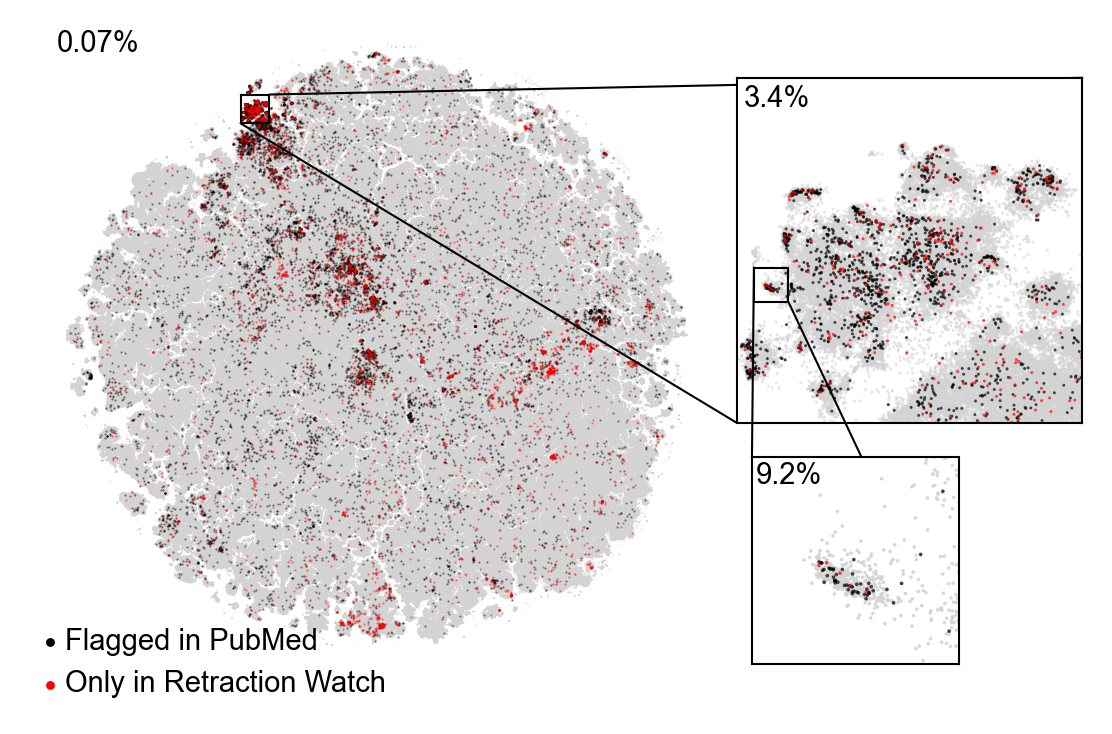

In [100]:
%matplotlib inline
fig = plt.figure(figsize=(3.6, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

## large embedding
ax0 = fig.add_axes([0.02, 0, 0.6, 1])  # [left, bottom, width, height]
x_lim = (-225, 225)
y_lim = (-225, 225)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax0.scatter(
    *tsne.T,
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)

ax0.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax0.scatter(
    *subregion_rw.T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)
# fraction
ax0.text(
    0,
    1,
    f"{(subregion.shape[0] + subregion_rw.shape[0]) / tsne.shape[0] * 100:.2f}%",
    fontsize=7,
    transform=ax0.transAxes,
    va="top",
    ha="left",
)

# legend
legend_fontsize = 7
point1 = ax0.scatter(
    [], [], c="black", s=5, alpha=1, label="Flagged in PubMed"
)
point2 = ax0.scatter(
    [], [], c="red", s=5, alpha=1, label="Only in Retraction Watch"
)
ax0.legend(
    handles=[point1, point2],
    loc="lower left",
    fontsize=legend_fontsize,
    frameon=False,
    borderpad=0.2,
    handletextpad=0,
    handlelength=1,
    borderaxespad=-0.9,
)

ax0.axis("square")
ax0.set_xlim(x_lim[0], x_lim[1])
ax0.set_ylim(y_lim[0], y_lim[1])
ax0.axis("off")


## inset 1
ax1 = fig.add_axes([0.65, 0.4, 0.32, 0.5])  # [left, bottom, width, height]

right = -77
left = -97
top = 180
bottom = 160

s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)
# fraction
ax1.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax1.transAxes,
    va="top",
    ha="left",
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
ax1.set_xticks([])
ax1.set_yticks([])


# lines
c = "k"
lw = 0.5
ax0.plot([left, right], [top, top], linewidth=lw, c=c)
ax0.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax0.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax0.plot([right, right], [bottom, top], linewidth=lw, c=c)


ax0.annotate(
    "",
    xytext=(left, bottom),
    textcoords="data",
    xy=(0, 0),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)
ax0.annotate(
    "",
    xytext=(right, top),
    textcoords="data",
    xy=(1, 1),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)


## inset 2

ax2 = fig.add_axes([0.6, 0.05, 0.32, 0.3])  # [left, bottom, width, height]

right = -94
left = -96
top = 169
bottom = 167

# manually
s_grey = 3
s_color = 3
alpha_grey = 0.9
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax2.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax2.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax2.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

# fraction
ax2.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax2.transAxes,
    va="top",
    ha="left",
)

ax2.axis("square")
ax2.set_xlim(left, right)
ax2.set_ylim(bottom, top)
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.axis("off")

# lines

c = "k"
lw = 0.5
ax1.plot([left, right], [top, top], linewidth=lw, c=c)
ax1.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax1.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax1.plot([right, right], [bottom, top], linewidth=lw, c=c)


# lw = 0.5
ax1.annotate(
    "",
    xytext=(left, top),
    textcoords="data",
    xy=(0, 1),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)
ax1.annotate(
    "",
    xytext=(right, bottom),
    textcoords="data",
    xy=(1, 0),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)


fig.savefig(
    figures_path / "fig_6_retracted_papers_v1.png",
    dpi=500,
)
# fig.savefig(
#     figures_path / "fig_6_retracted_papers_v1.pdf",
#     dpi=500,
# )

### Figure with countries

In [47]:
# load
colors_countries_first_author = np.load(
    variables_path
    / "colors_countries_first_author_2024_usa_corrected_with_black.npy",
    allow_pickle=True,
)

# legend colors
pickle_in = open(variables_path / "colors_countries_legend_2024.pkl", "rb")
colors_countries_legend = pickle.load(pickle_in)

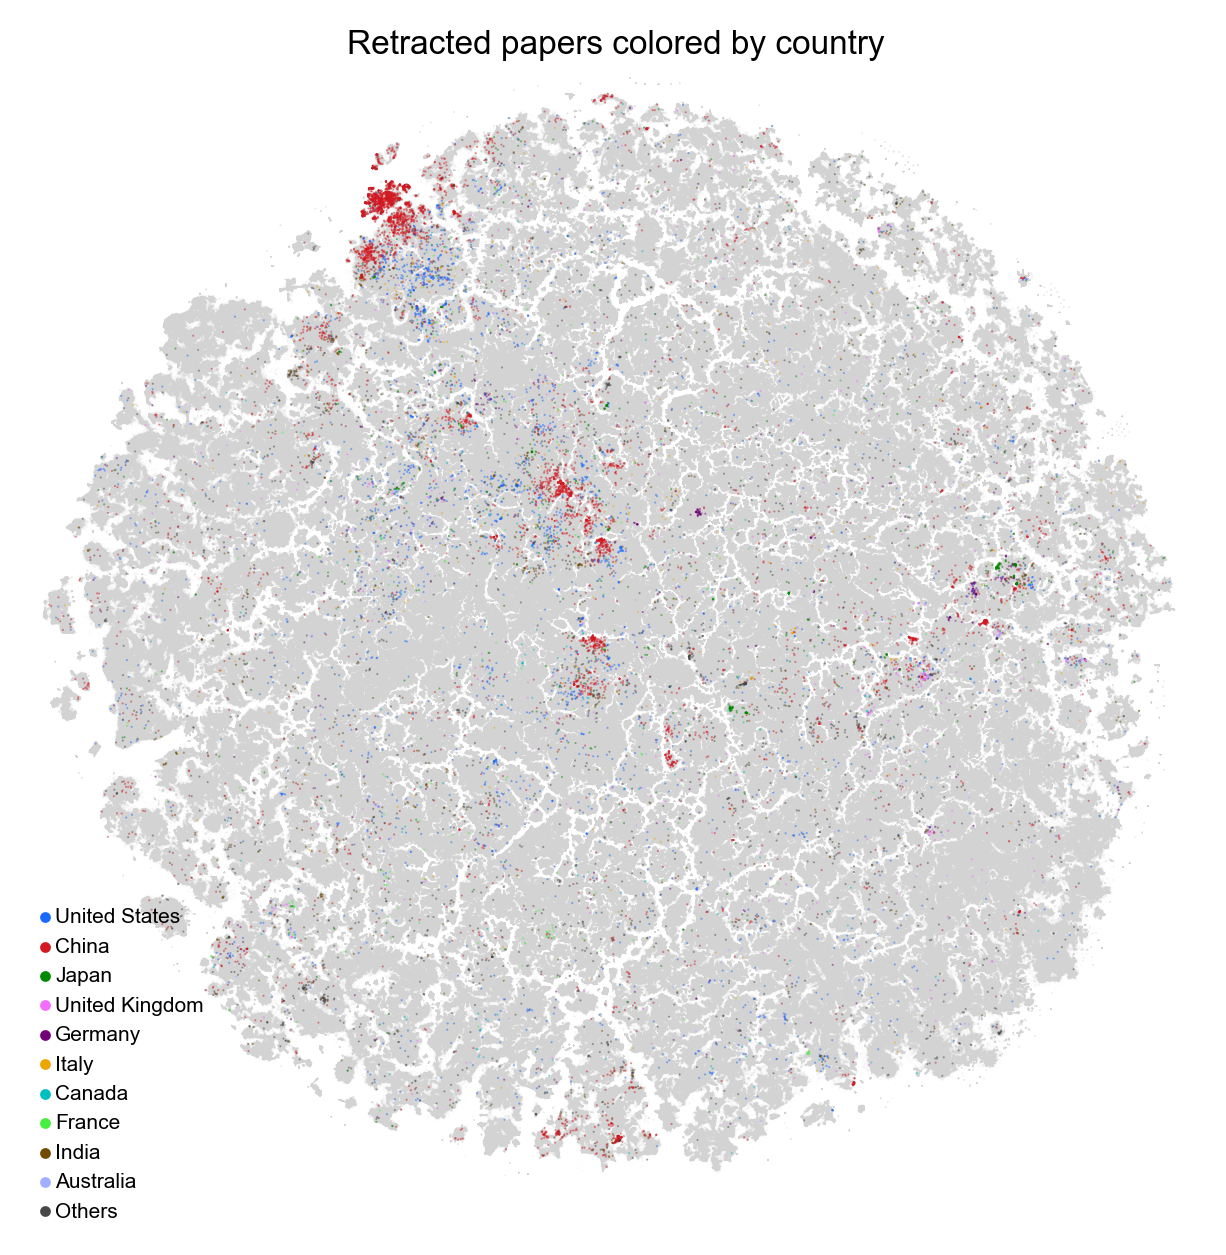

In [49]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-220, 220)
y_lim = (-220, 220)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]
colors_subregion = colors_countries_first_author[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]
colors_subregion_rw = colors_countries_first_author[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]


ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)


ax.scatter(
    *subregion.T,
    s=s_color,
    c=colors_subregion,
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.scatter(
    *subregion_rw.T,
    s=s_color,
    c=colors_subregion_rw,
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

all_keys = []
for key, value in colors_countries_legend.items():
    key = ax.scatter([], [], c=value, s=10, alpha=1, label=key)
    all_keys.append(key)
key = ax.scatter([], [], c="#474747", s=10, alpha=1, label="Others")
all_keys.append(key)


ax.legend(
    handles=all_keys,
    loc="lower left",
    fontsize=5,
    frameon=False,
    borderpad=0.2,
    handletextpad=0,
    handlelength=1,
    borderaxespad=-0.2,
)  # -0.2 before


ax.set_title("Retracted papers colored by country")
ax.axis("equal")
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.axis("off")

fig.savefig(
    figures_path / "tsne_colored_by_country_and_retracted_papers_v3.png"
)

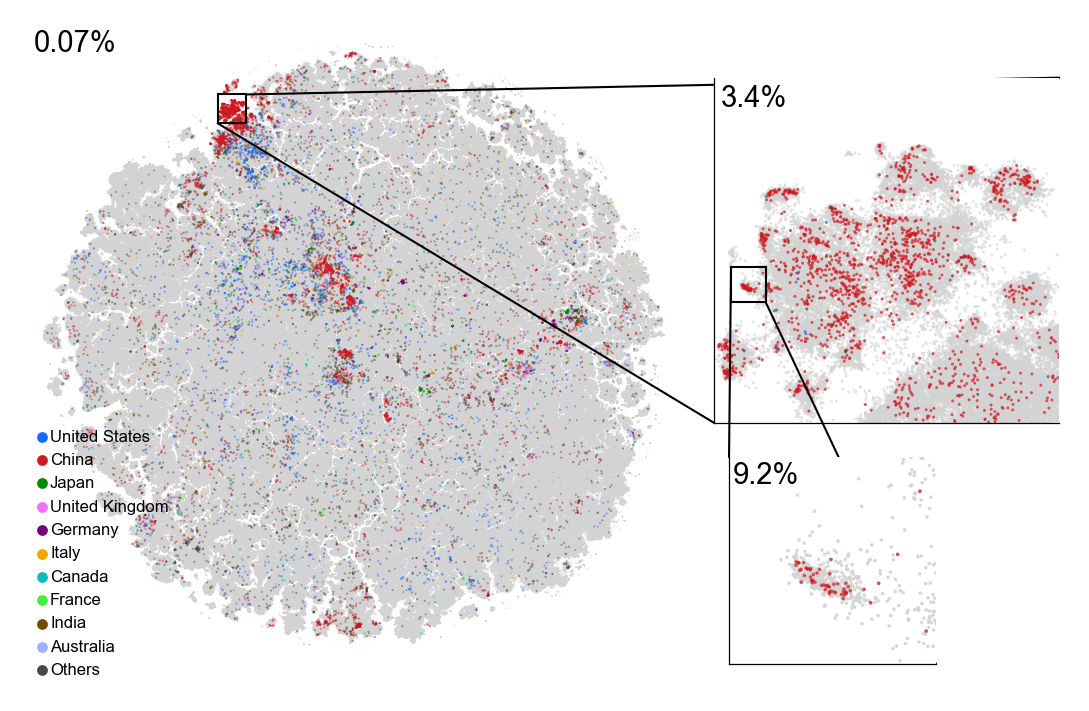

In [50]:
%matplotlib inline
fig = plt.figure(figsize=(3.6, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

## large embedding
ax0 = fig.add_axes([0.02, 0, 0.6, 1])  # [left, bottom, width, height]
x_lim = (-225, 225)
y_lim = (-225, 225)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

colors_subregion = colors_countries_first_author[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]
colors_subregion_rw = colors_countries_first_author[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax0.scatter(
    *tsne.T,
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)

ax0.scatter(
    *subregion.T,
    s=s_color,
    c=colors_subregion,
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax0.scatter(
    *subregion_rw.T,
    s=s_color,
    c=colors_subregion_rw,
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)
# fraction
ax0.text(
    0,
    1,
    f"{(subregion.shape[0] + subregion_rw.shape[0]) / tsne.shape[0] * 100:.2f}%",
    fontsize=7,
    transform=ax0.transAxes,
    va="top",
    ha="left",
)

# legend
all_keys = []
for key, value in colors_countries_legend.items():
    key = ax0.scatter([], [], c=value, s=10, alpha=1, label=key)
    all_keys.append(key)

key = ax0.scatter([], [], c="#474747", s=10, alpha=1, label="Others")
all_keys.append(key)


ax0.legend(
    handles=all_keys,
    loc="lower left",
    fontsize=4,
    frameon=False,
    borderpad=0.2,
    handletextpad=0,
    handlelength=1,
    borderaxespad=-0.2,
)  # -0.2 before

ax0.axis("square")
ax0.set_xlim(x_lim[0], x_lim[1])
ax0.set_ylim(y_lim[0], y_lim[1])
ax0.axis("off")


## inset 1
ax1 = fig.add_axes([0.65, 0.4, 0.32, 0.5])  # [left, bottom, width, height]

right = -77
left = -97
top = 180
bottom = 160

s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c=colors_subregion[mask_retracted_zoom],
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c=colors_subregion_rw[mask_retracted_rw_zoom],
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)
# fraction
ax1.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax1.transAxes,
    va="top",
    ha="left",
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
ax1.set_xticks([])
ax1.set_yticks([])


# lines
c = "k"
lw = 0.5
ax0.plot([left, right], [top, top], linewidth=lw, c=c)
ax0.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax0.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax0.plot([right, right], [bottom, top], linewidth=lw, c=c)


ax0.annotate(
    "",
    xytext=(left, bottom),
    textcoords="data",
    xy=(0, 0),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)
ax0.annotate(
    "",
    xytext=(right, top),
    textcoords="data",
    xy=(1, 1),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)


## inset 2

ax2 = fig.add_axes([0.6, 0.05, 0.32, 0.3])  # [left, bottom, width, height]

right = -94
left = -96
top = 169
bottom = 167

# manually
s_grey = 3
s_color = 3
alpha_grey = 0.9
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax2.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax2.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c=colors_subregion[mask_retracted_zoom],
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax2.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c=colors_subregion_rw[mask_retracted_rw_zoom],
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

# fraction
ax2.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax2.transAxes,
    va="top",
    ha="left",
)

ax2.axis("square")
ax2.set_xlim(left, right)
ax2.set_ylim(bottom, top)
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.axis("off")

# lines

c = "k"
lw = 0.5
ax1.plot([left, right], [top, top], linewidth=lw, c=c)
ax1.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax1.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax1.plot([right, right], [bottom, top], linewidth=lw, c=c)


# lw = 0.5
ax1.annotate(
    "",
    xytext=(left, top),
    textcoords="data",
    xy=(0, 1),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)
ax1.annotate(
    "",
    xytext=(right, bottom),
    textcoords="data",
    xy=(1, 0),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)


fig.savefig(
    figures_path / "tsne_colored_by_country_and_retracted_papers_v4.png",
    dpi=500,
)